In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol

In [43]:
Ainit = 1e-5
kon = 1e5
k = Ainit*kon
koff = 1e-4
qon = 6.5e3
q = qon*Ainit
qoff = 4.7e-3

delta2 = 10
delta4 = 10
delta7 = 10
delta5 = delta4*delta7/delta2
delta6 = delta4
k1 = 2*k
k1off = koff
k2 = delta2*k
k2off = 2*koff
k3 = q
k3off = qoff
k4 = delta4*q
k4off = qoff
k5 = delta5*q
k5off = qoff
k6 = 2*delta6*k
k6off = koff
k7 = delta7*k
k7off = 2*koff

alpha1 = k1/k1off
alpha2 = k2/k1off
gamma2 = k2off/k1off
alpha3 = k3/k1off
gamma3 = k3off/k1off
alpha4 = k4/k1off
gamma4 = k4off/k1off
alpha5 = k5/k1off
gamma5 = k5off/k1off
alpha6 = k6/k1off
gamma6 = k6off/k1off
alpha7 = k7/k1off
gamma7 = k7off/k1off

Target_cell_number = 5e3
Atot = 1e16*Ainit/Target_cell_number
rtot = 1e5
beta_t = Atot/rtot
phi = 2
beta_f = beta_t*phi

In [44]:
def model_v2(z):

    A00 = 1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4]) - (1/beta_f)*z[2]
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

roots = fsolve(model_v2, [0.2, 0.2, 0.2, 0.2, 0.2])

In [45]:
print(roots)

[9.53646241e-01 1.14519002e-02 9.53476917e-01 2.28997338e-02
 2.74992398e-04]


In [46]:

A10 = Symbol('A10', real=True)
A20 = Symbol('A20', real=True)
A01 = Symbol('A01', real=True)
A11 = Symbol('A11', real=True)
A21 = Symbol('A21', real=True)

dA10 = alpha1*beta_t*(1 - (1/beta_t)*(A10 + A20 + A11 + A21) - (1/beta_f)*A01)*(1- A10 - A11 - 2*(A20 + A21)) - A10 - alpha2*A10*(1- A10 - A11 - 2*(A20 + A21)) + gamma2*A20 - alpha4*A10*(1 - A01 - phi*(A11 + A21)) + gamma4*A11
dA20 = alpha2*A10*(1- A10 - A11 - 2*(A20 + A21)) - gamma2*A20 - alpha5*A20*(1 - A01 - phi*(A11 + A21)) + gamma5*A21
dA01 = alpha3*beta_f*(1 - (1/beta_t)*(A10 + A20 + A11 + A21) - (1/beta_f)*A01)*(1 - A01 - phi*(A11 + A21)) - gamma3*A01 - alpha6*A01*(1- A10 - A11 - 2*(A20 + A21)) + gamma6*phi*A11
dA11 = alpha4*A10*(1 - A01 - phi*(A11 + A21)) - gamma4*A11 + (alpha6/phi)*A01*(1- A10 - A11 - 2*(A20 + A21)) - gamma6*A11 - alpha7*A11*(1- A10 - A11 - 2*(A20 + A21)) + gamma7*A21
dA21 = alpha5*A20*(1 - A01 - phi*(A11 + A21)) - gamma5*A21 + alpha7*A11*(1- A10 - A11 - 2*(A20 + A21)) - gamma7*A21

#val = solve([dA10, dA20, dA01, dA11, dA21], (A10, A20, A01, A11, A21))


Sensitivity analysis for amount of fc bound

In [47]:
def single_cell_model(t, z, delta, A_0):
    
    Ainit = A_0
    kon = 1e5
    k = Ainit*kon
    k1 = 2*k
    k1off = koff
    alpha1 = k1/k1off
    Target_cell_number = 5e3
    Atot = 1e16*Ainit/Target_cell_number
    rtot = 1e5
    beta_t = Atot/rtot
    dA1 = alpha1*(1-z[0]-2*z[1])*(beta_t-z[0]-z[1]) - z[0] - delta*alpha1*(1-z[0]-2*z[1])*z[0] + 2*z[1]
    dA2 = delta*alpha1*(1-z[0]-2*z[1])*z[0] - 2*z[1]

    return [dA1, dA2]

def single_cell_stst(delta, A_0):
    t_end = 100
    t = np.geomspace(1e-8, t_end, 500)
    tspan = [0, t_end]
    z0 = [0, 0]

    # solve single cell model to obtain equilibrium values
    # to use as ics for A10 and A20 in two cell model
    z = solve_ivp(single_cell_model, tspan, z0, method='Radau', args=(delta, A_0), t_eval=t)
    A1 = z.y[0]
    A2 = z.y[1]
    A1_stst = A1[-1]
    A2_stst = A2[-1]

    return [A1_stst, A2_stst]

def two_cells(t, z, phi, delta2, delta4, delta7, A_0):

    Ainit = A_0
    kon = 1e5
    k = Ainit*kon
    koff = 1e-4
    qon = 6.5e3
    q = qon*Ainit
    qoff = 4.7e-3
    delta5 = delta4*delta7/delta2
    delta6 = delta4
    k1 = 2*k
    k1off = koff
    k2 = delta2*k
    k2off = 2*koff
    k3 = q
    k3off = qoff
    k4 = delta4*q
    k4off = qoff
    k5 = delta5*q
    k5off = qoff
    k6 = 2*delta6*k
    k6off = koff
    k7 = delta7*k
    k7off = 2*koff

    alpha1 = k1/k1off
    alpha2 = k2/k1off
    gamma2 = k2off/k1off
    alpha3 = k3/k1off
    gamma3 = k3off/k1off
    alpha4 = k4/k1off
    gamma4 = k4off/k1off
    alpha5 = k5/k1off
    gamma5 = k5off/k1off
    alpha6 = k6/k1off
    gamma6 = k6off/k1off
    alpha7 = k7/k1off
    gamma7 = k7off/k1off

    Target_cell_number = 5e3
    Atot = 1e16*Ainit/Target_cell_number
    rtot = 1e5
    beta_t = Atot/rtot
    beta_f = beta_t*phi

    A00 = 1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4]) - (1/beta_f)*z[2]
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + gamma2*z[1] - alpha4*z[0]*(rf) + gamma4*z[3]
    dA20 = alpha2*z[0]*(rt) - gamma2*z[1] - alpha5*z[1]*(rf) + gamma5*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma3*z[2] - alpha6*z[2]*(rt) + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma4*z[3] + (alpha6/phi)*z[2]*(rt) - gamma6*z[3] - alpha7*z[3]*(rt) + gamma7*z[4]
    dA21 = alpha5*z[1]*(rf) - gamma5*z[4] + alpha7*z[3]*(rt) - gamma7*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def calc_fc(phi, delta2, delta4, delta7, A_0):

    ICS = single_cell_stst(delta2, A_0)
    tend = 1000
    t = np.geomspace(1e-10, tend, 100)
    z0 = [ICS[0], ICS[1], 0, 0, 0]
    t_span = [1e-10, tend]
    z = solve_ivp(two_cells, t_span, z0, method='Radau', t_eval=t, args=(phi, delta2, delta4, delta7, A_0))

    A11 = z.y[3]
    A21 = z.y[4]
    fc = A11[-1] + A21[-1]

    return fc
    

In [48]:
problem = {
    'num_vars': 4,
    'names': ['phi', 'delta2', 'delta4', 'delta7'],
    'bounds': [[0.1, 2],
               [0.1, 50],
               [0.1, 50],
               [0.1, 50]]
}

# generate samples
lost = []
vals = saltelli.sample(problem, 256)

Y = np.zeros(len(vals))
indicies = []
A0s = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
for A_0 in A0s:
    for i in range(len(vals)):
        params = vals[i]
        phi = params[0]
        delta2 = params[1]
        delta4 = params[2]
        delta7 = params[3]
        Y[i] = calc_fc(phi, delta2, delta4, delta7, A_0)
        Si = sobol.analyze(problem, Y)
    indicies.append(Si['ST'])
    lost.append(Si)


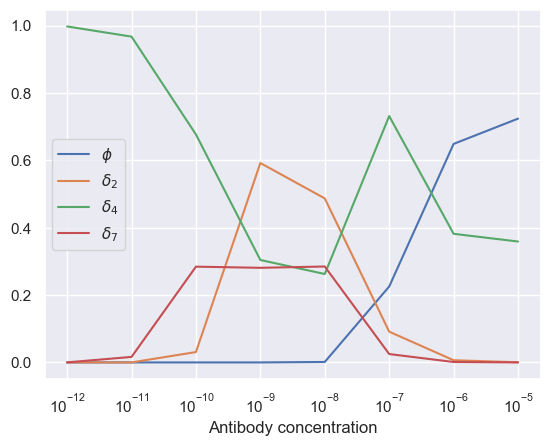

In [54]:
phi_si = []
delta2_si = []
delta4_si = []
delta7_si = []

for i in range(len(indicies)):
    vals = indicies[i]
    phi_si.append(vals[0])
    delta2_si.append(vals[1])
    delta4_si.append(vals[2])
    delta7_si.append(vals[3])

data = [phi_si, delta2_si, delta4_si, delta7_si]
labels = [r'$\phi$', r'$\delta_2$', r'$\delta_4$', r'$\delta_7$']

sns.set_theme()

for i in range(len(data)):
    plt.plot(A0s, data[i], label=labels[i])


plt.xscale('log')
plt.xlabel('Antibody concentration')
plt.legend(loc='best')
plt.show()

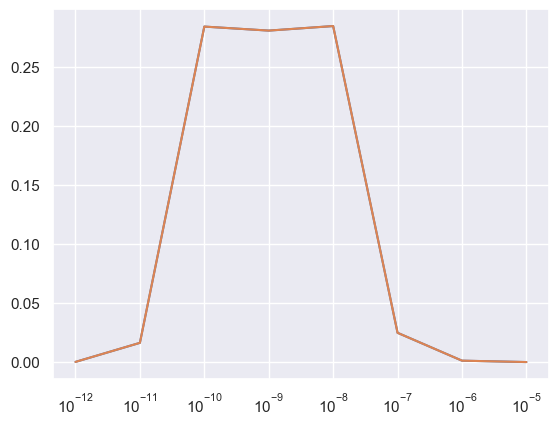

In [51]:
plt.semilogx(A0s, delta4_si)
plt.semilogx(A0s, delta7_si)